# False Positive Trainer Notebook

By executing the notebook you will train a simple false positive detector.  
The Detector is based on a Logistic Classifier, which is trained on a set of features extracted from the images.  
The extracted features are the Solidity and the Arclength divided by the root of the area.


In [24]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from joblib import dump, load
import json

np.random.seed(42)

## Setting some constants

| Parameter | Description                                                                                                                 |
| --------- | --------------------------------------------------------------------------------------------------------------------------- |
| DATA_PATH | The directory of the dataset; for more information on the formatting please read the [Dataset Guide](../Datasets/README.md) |
| SAVE_DIR  | The directory where to save the trained model                                                                               |


In [25]:
DATA_PATH = os.path.join(os.getcwd(), "..", "Datasets", "FalsePositiveDetectorDataset")
SAVE_DIR = os.path.join(os.getcwd(), "models")

## Loading the Paths

In the first step we load the paths to all the images from the dataset.  
We will use these paths to load the images and masks in the next step.


In [26]:
splits = ["train", "test"]

mask_paths = {}
annotations = {}
labels = {}

for split in splits:
    annotations[split] = json.load(
        open(os.path.join(DATA_PATH, split, "annotations.json"), "r")
    )
    mask_paths[split] = [
        os.path.join(DATA_PATH, split, "masks", image_name + ".png")
        for image_name in annotations[split].keys()
    ]
    labels[split] = [
        annotations[split][image_name] for image_name in annotations[split].keys()
    ]

## Loading the Data and extracting the features

In this step the data is loaded and the features are extracted.


In [27]:
solidities = {"train": [], "test": []}
arcareas = {"train": [], "test": []}

for split in splits:
    print(f"Processing {split} split")
    for idx, mask_path in enumerate(mask_paths[split]):
        print(f"{idx}/{len(mask_paths[split])}", end="\r")

        mask = cv2.imread(mask_path, 0)

        contours, _ = cv2.findContours(mask, 1, cv2.CHAIN_APPROX_SIMPLE)

        # we only need the top-level contour
        # We also assume that each mask only has one contour
        contour = contours[0]

        convex_hull = cv2.convexHull(contour)
        convex_hull_area = cv2.contourArea(convex_hull)
        arclength = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        solidity = float(area) / convex_hull_area

        solidities[split].append(solidity)
        arcareas[split].append(arclength / area**0.5)
    print("\nDone")

Processing train split
1928/1929
Done
Processing test split
578/579
Done


## Preprocessing the data

In order to use the data for training, we need to preprocess it.  
The data is stored in a directory structure that is compatible with the training process.


In [28]:
solidities_0 = {}
solidities_1 = {}
arcareas_0 = {}
arcareas_1 = {}

for split in splits:
    solidities_1[split] = np.array(
        [
            value
            for idx, value in enumerate(solidities[split])
            if labels[split][idx] == 1
        ]
    )
    solidities_0[split] = np.array(
        [
            value
            for idx, value in enumerate(solidities[split])
            if labels[split][idx] == 0
        ]
    )

    arcareas_1[split] = np.array(
        [value for idx, value in enumerate(arcareas[split]) if labels[split][idx] == 1]
    )
    arcareas_0[split] = np.array(
        [value for idx, value in enumerate(arcareas[split]) if labels[split][idx] == 0]
    )

X_train = np.array([arcareas["train"], solidities["train"]]).T
y_train = np.array(labels["train"])

X_test = np.array([arcareas["test"], solidities["test"]]).T
y_test = np.array(labels["test"])

X_full = np.array(
    [arcareas["train"] + arcareas["test"], solidities["train"] + solidities["test"]]
).T
y_full = np.array(labels["train"] + labels["test"])

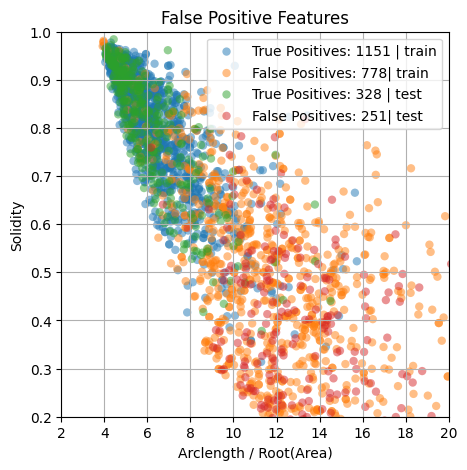

In [29]:
plt.figure(figsize=(5, 5))

for split in splits:
    plt.scatter(
        arcareas_1[split],
        solidities_1[split],
        alpha=0.5,
        label=f"True Positives: {len(arcareas_1[split])} | {split}",
        ec="None",
    )
    plt.scatter(
        arcareas_0[split],
        solidities_0[split],
        alpha=0.5,
        label=f"False Positives: {len(arcareas_0[split])}| {split}",
        ec="None",
    )

plt.xlim(2, 20)
plt.ylim(0.2, 1)

plt.title(f"False Positive Features")
plt.grid(True)
plt.legend()
plt.xlabel("Arclength / Root(Area)")
plt.ylabel("Solidity")
plt.show()

## Defining the Model

The used model is a simple logistic regressor as the previous plot shows that the data is linearly separable.  
You may try out different models and see if they perform better.  
One example would be a neural network with a single hidden layer or the SVM classifier that is commented out below.


In [30]:
from sklearn.linear_model import LogisticRegression

# from sklearn.svm import SVC

classifiers = {
    "L2_logistic": LogisticRegression(
        C=1,
        penalty="l2",
        solver="saga",
        max_iter=10000,
        class_weight="balanced",
    ),
    # "Support_Vector_Classifier": SVC(
    #     kernel="linear",
    #     class_weight="balanced",
    #     max_iter=10000,
    #     probability=True,
    # ),
}

L2_logistic | ACC: 93.61% | REC: 89.63% | PRE: 98.99% | F1: 94.08%


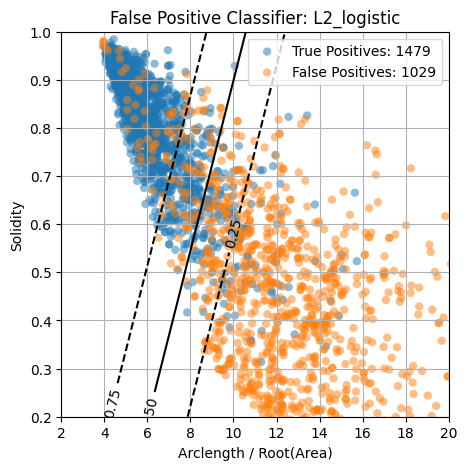

In [31]:
Classes = ["True Positive", "False Positive"]

xx = np.linspace(0, 20, 1000)
yy = np.linspace(0.2, 1, 1000).T
xx, yy = np.meshgrid(xx, yy)
X_mesh = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    # fitting on the train set
    classifier.fit(X_train, y_train)

    # save the classifier
    dump(classifier, f"{SAVE_DIR}/classifier_{name}.joblib")
    classifier = load(f"{SAVE_DIR}/classifier_{name}.joblib")

    # predict on the test set
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(
        f"{name} | ACC: {accuracy:.2%} | REC: {recall:.2%} | PRE: {precision:.2%} | F1: {f1:.2%}"
    )

    # View probabilities:
    probas = classifier.predict_proba(X_mesh)

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.xlim(2, 20)
    plt.ylim(0.2, 1)

    CS = ax.contour(
        xx,
        yy,
        probas[:, 1].reshape((1000, 1000)),
        levels=[0.25, 0.5, 0.75],
        colors="k",
        linestyles=["--", "-", "--"],
    )
    ax.clabel(CS, inline=True, fontsize=10, fmt="%1.2f")

    # plot the decision boundary and the full dataset
    arcareas_0_all = np.concatenate((arcareas_0["train"], arcareas_0["test"]))
    arcareas_1_all = np.concatenate((arcareas_1["train"], arcareas_1["test"]))
    solidities_0_all = np.concatenate((solidities_0["train"], solidities_0["test"]))
    solidities_1_all = np.concatenate((solidities_1["train"], solidities_1["test"]))

    plt.scatter(
        arcareas_1_all,
        solidities_1_all,
        alpha=0.5,
        label=f"True Positives: {len(arcareas_1_all)}",
        ec="None",
    )
    plt.scatter(
        arcareas_0_all,
        solidities_0_all,
        alpha=0.5,
        label=f"False Positives: {len(arcareas_0_all)}",
        ec="None",
    )

    plt.title(f"False Positive Classifier: {name}")
    plt.grid(True)
    plt.legend()
    plt.xlabel("Arclength / Root(Area)")
    plt.ylabel("Solidity")
    plt.show()